<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Human-Innate-Immune-System-Feels-the-Heat" data-toc-modified-id="Human-Innate-Immune-System-Feels-the-Heat-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Human Innate Immune System Feels the Heat</a></span></li></ul></div>

# Human Innate Immune System Feels the Heat

Eplore how heat affects the human innate immune system.

In [2]:
import sys
sys.path.append("../")

from scipy.interpolate import interp1d
from matplotlib.pyplot import cm

import numpy as np
import decimal
import scipy as s
import csv as c
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt
import _pickle as pickle

# import Parameters as prms
from heat import Parameters as prms
# import APPIREDII_Cytokines_Parser as cyto
# import APPIREDII_Blood_Params_Parser as dp

"""
Code to model the innate immune response coupled with the Alkaline Phosphatase simulator.
Created on Thu Mar 10 11:24:36 2016. Runtime is in minutes.
"""

__author__ = "Louella Alva Presbitero"


sns.set_palette("deep")
sns.set_color_codes("deep")


def vectorfield(w, t, p, params):
    """
    Define differential equations for the innate immune system.

    Arguments:
        w : vector of the state variables
            w=[N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH,
            N_A, ND_A, ACH, ND_N]
        t : time
        p : vector of the parameters
    """
#     print (t)

    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH, N_A, ND_A, \
    ACH, ND_N = pre_vectorfield(w, params)

    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width = p

    hypothesis = 0
    CH_delay = 20
    NDA_delay = 5. * 60.
    delay_AP = 60.

    f_dillution = 1./16. # (80/5) ratio betweenblood tissue compartment and blood compartment

    t_ITM = 10.
    t_ITM_source = 5. * 60.
    t_inject = 8. * 60.

    if params['h'] == 'h4':
        hypothesis = (rinduce_peak / (1 + np.exp(rinduce*(t - delay_AP)))) * (AP_Sblood + AP_Stissue)

    hypothesis *= int(not (hypothesis < 0))

    if params['restrict']:
        source_ITM = ITM_source_peak * np.exp(-(1. / (2. * (ITM_source_width ** 2))) * (t - t_ITM_source) ** 2)
    else:
        source_ITM = 0

    f = [
        # N_R
        - mu_NR * N_R
        - (Pmax_NR * (CH / (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R
        + (r_Nhomeo * (1. - N_R / Nmax) * N_R) * (int(not (N_R < 0)))
        ,

        # AP_Eblood
        - mu_APE * AP_Eblood
        - lamb_APE * AP_Eblood * ITMblood
        - ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood
        + (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2))) * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Etissue
        - mu_APE * AP_Etissue
        - lamb_APE * AP_Etissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood,

        # AP_Eliver
        (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2))) * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Sblood
        (- mu_APS * AP_Sblood
         - lamb_APS * AP_Sblood * ITMblood
         + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
         - ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Sblood)
        * (int(not (AP_Sblood < 0))),

        # AP_Stissue
        - mu_APS * AP_Stissue
        - lamb_APS * AP_Stissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Sblood,

        # ITMblood
        (- mu_ITM * ITMblood
         - ITMblood * (lamb_APE * AP_Eblood + lamb_APS * AP_Sblood)
         - ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood * (1 - ITMtissue / ITMmax))
        * (int(not (ITMblood < 0)))
        + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))
#         + source_ITM
        ,

        # ITMtissue
        (- mu_ITM * ITMtissue
         - ITMtissue * (
             lamb_APE * AP_Etissue
             + lamb_APS * AP_Stissue
             + lamb_ITMMA * M_A
             + lamb_ITMNDN * N_A)
         + alpha_ITMNDN * ND_N
         + f_dillution * ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood
         * (1. - ITMtissue / ITMmax)) * (int(not (ITMtissue < 0))),

        # M_R
        - mu_MR * M_R - (phi_MRA * M_R * ITMtissue / (1 + theta_ACH * ACH))
        + (((Pmax_MR - Pmin_MR) * (CH / (CH + Keq_CH)) + Pmin_MR) * (Mmax - (M_A + M_R))),

        # M_A
        - mu_MA * M_A + (phi_MRA * M_R * ITMtissue) / (1 + theta_ACH * ACH),

        # CH
        (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
        (-mu_CH * CH
         + ((beta_CHNA * N_A * ITMtissue
             + beta_CHMA * M_A * ITMtissue) * (1 - CH / CHmax_tissue) / (1 + theta_ACH * ACH))),

        # N_A
        - mu_NDA * (N_A / (1 + ITMtissue))
        - (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (lamb_ITMNDN * (ITMtissue * N_A))
        + f_dillution * ((Pmax_NR) * (CH / (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R,

        # ND_A
        mu_NDA * (N_A / (1 + ITMtissue)) - lamb_MANDA * M_A * ND_A,

        # ACH
        (- mu_ACH * ACH + (alpha_ACHMA * M_A + beta_MANDA * M_A * ND_A) * (1 - ACH / ACHmax)),

        # ND_N
        (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (
        lamb_ITMNDN * (ITMtissue * N_A) - lamb_MANDN * M_A * ND_N
        )
    ]
    return post_vectorfield(f, w, params)


In [5]:
def change_temp(p, temp_alpha, Temperature, ITM_factor, T0):
#     Temperature = 36.8
#     p = get_p()
    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width = p
    
#     print('original', temp_alpha, ITM_factor, lamb_ITMNA, Pmax_NR, Nmax, lamb_ITMMA, beta_CHNA, beta_CHMA, alpha_ACHMA, Pmax_APE, alpha_ITMNDN)

    
    # difference between parameters is proportional to the change in temperature by a factor temp_alpha
#     print (Temperature, T0, temp_alpha, ITM_factor)
  
    params_temp = {
        'lamb_ITMNDN': lamb_ITMNDN,
        'Pmax_NR' : Pmax_NR,
        'Nmax': Nmax,
        'lamb_ITMMA' : lamb_ITMMA,
        'beta_CHNA' : beta_CHNA,
        'beta_CHMA' : beta_CHMA,
        'alpha_ACHMA' : alpha_ACHMA,
        'Pmax_APE' : Pmax_APE,
        'alpha_ITMNDN': alpha_ITMNDN
    }
        
    params_standardized, scaler = standardize_params(params_temp)
        
    lamb_ITMNDN_s = params_standardized['lamb_ITMNDN']*np.exp(temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))#+ temp_alpha * (Temperature - T0) # trend not too clear
    Pmax_NR_s = params_standardized['Pmax_NR'] + (temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong direction
    Nmax_s = params_standardized['Nmax'] + (temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # moving in right direction
    lamb_ITMMA_s = params_standardized['lamb_ITMMA'] + (temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong trend, ITMs are higher first?
  
    beta_CHNA_s = params_standardized['beta_CHNA'] + (temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))#  + temp_alpha * (Temperature - T0) # decrease, right direction
    beta_CHMA_s = params_standardized['beta_CHMA'] + (temp_alpha * float(Temperature - T0)) #* np.exp(temp_alpha * (Temperature - T0))#  + temp_alpha * (Temperature - T0) # decrease, right direction
    
    alpha_ACHMA_s = params_standardized['alpha_ACHMA'] +(temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # right direction
#     alpha_ACHMA_s = params_standardized['alpha_ACHMA'] *np.exp(temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # right direction
    Pmax_APE_s = params_standardized['Pmax_APE'] + (temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong direction

    
    alpha_ITMNDN_s = params_standardized['alpha_ITMNDN'] * np.exp(ITM_factor * float(Temperature - T0))


    reversed_standardized = reverse_standardize(params_temp, [lamb_ITMNDN_s, Pmax_NR_s, Nmax_s, lamb_ITMMA_s, beta_CHNA_s, 
                                                 beta_CHMA_s, alpha_ACHMA_s, Pmax_APE_s, alpha_ITMNDN_s], scaler)
    
#     print (reversed_standardized)
    lamb_ITMNDN_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new = list(reversed_standardized.values())
    
    new_list= [lamb_ITMNDN_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new]
#     print (Temperature, T0, temp_alpha, ITM_factor)
#     print('after', temp_alpha, ITM_factor, lamb_ITMNA_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new)
    for index, key in enumerate(params_temp_track.keys()):
        params_temp_track[key].append(new_list[index])
    
    p_new = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax_new, Pmax_MR, Pmax_NR_new, Keq_CH, phi_MRA,theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA_new, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA_new, beta_CHMA_new, beta_CHNA_new, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN_new, alpha_ITMNDN_new, Pmax_APE_new,Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max, r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width]
    
    return p_new, scaler

In [6]:
def change_temp_(p, temp_alpha, Temperature, ITM_factor, T0):
#     Temperature = 36.5
#     p = get_p()
    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width = p
    
#     print('original', temp_alpha, ITM_factor, lamb_ITMNA, Pmax_NR, Nmax, lamb_ITMMA, beta_CHNA, beta_CHMA, alpha_ACHMA, Pmax_APE, alpha_ITMNDN)

    
    # difference between parameters is proportional to the change in temperature by a factor temp_alpha
#     print (Temperature, T0, temp_alpha, ITM_factor)
  
    params_temp = {
        'lamb_ITMNDN': lamb_ITMNDN,
        'Pmax_NR' : Pmax_NR,
        'Nmax': Nmax,
        'lamb_ITMMA' : lamb_ITMMA,
        'beta_CHNA' : beta_CHNA,
        'beta_CHMA' : beta_CHMA,
        'alpha_ACHMA' : alpha_ACHMA,
        'Pmax_APE' : Pmax_APE,
        'alpha_ITMNDN': alpha_ITMNDN
    }
        
    params_standardized, scaler = standardize_params(params_temp)
    ####
    # Lera's eqn
    
#     Pmax_NR_s = params_temp['Pmax_NR'] *(1+ temp_alpha) * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong direction
    
    
    
    ####
    lamb_ITMNDN_s = params_standardized['lamb_ITMNDN']*np.exp(temp_alpha * float(Temperature - T0))#* np.exp(temp_alpha * (Temperature - T0))#+ temp_alpha * (Temperature - T0) # trend not too clear
    Pmax_NR_s = params_standardized['Pmax_NR'] + (params_standardized['Pmax_NR']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong direction
    Nmax_s = params_standardized['Nmax'] + (params_standardized['Nmax']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # moving in right direction
    lamb_ITMMA_s = params_standardized['lamb_ITMMA'] + (params_standardized['lamb_ITMMA']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong trend, ITMs are higher first?
  
    beta_CHNA_s = params_standardized['beta_CHNA'] + (params_standardized['beta_CHNA']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))#  + temp_alpha * (Temperature - T0) # decrease, right direction
    beta_CHMA_s = params_standardized['beta_CHMA'] + (params_standardized['beta_CHMA']/temp_alpha) * float(Temperature - T0) #* np.exp(temp_alpha * (Temperature - T0))#  + temp_alpha * (Temperature - T0) # decrease, right direction
    
    alpha_ACHMA_s = params_standardized['alpha_ACHMA'] +(params_standardized['alpha_ACHMA']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # right direction
    Pmax_APE_s = params_standardized['Pmax_APE'] + (params_standardized['Pmax_APE']/temp_alpha) * float(Temperature - T0)#* np.exp(temp_alpha * (Temperature - T0))# + temp_alpha * (Temperature - T0) # wrong direction

    
    alpha_ITMNDN_s = params_standardized['alpha_ITMNDN'] * np.exp(ITM_factor * float(Temperature - T0))


    reversed_standardized = reverse_standardize(params_temp, [lamb_ITMNDN_s, Pmax_NR_s, Nmax_s, lamb_ITMMA_s, beta_CHNA_s, 
                                                 beta_CHMA_s, alpha_ACHMA_s, Pmax_APE_s, alpha_ITMNDN_s], scaler)
    
#     print (reversed_standardized)
    lamb_ITMNDN_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new = list(reversed_standardized.values())
    
    new_list= [lamb_ITMNDN_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new]
#     print (Temperature, T0, temp_alpha, ITM_factor)
#     print('after', temp_alpha, ITM_factor, lamb_ITMNA_new, Pmax_NR_new, Nmax_new, lamb_ITMMA_new, beta_CHNA_new, beta_CHMA_new, alpha_ACHMA_new, Pmax_APE_new, alpha_ITMNDN_new)
    for index, key in enumerate(params_temp_track.keys()):
        params_temp_track[key].append(new_list[index])
    
    p_new = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax_new, Pmax_MR, Pmax_NR_new, Keq_CH, phi_MRA,theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA_new, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA_new, beta_CHMA_new, beta_CHNA_new, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN_new, alpha_ITMNDN_new, Pmax_APE_new,Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max, r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width]
    
    return p_new, scaler

In [7]:
def to_min(t):
    set_t = set_time(t, time)
    if time == 'sec':
        return set_t / 60
    elif time == 'min':
        return t
    elif time == 'hours':
        return t * 60
    elif time == 'days':
        return t * 1440


def pre_vectorfield(w, params):
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = w
    if params['case'] == 0:
        N_R = AP_Eblood = AP_Etissue, AP_Eliver = AP_Sblood = AP_Stissue = M_R = M_A = CH = N_A = ND_A = ACH = ND_N = 0
    elif params['case'] == 1:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = CH = ACH = 0
    elif params['case'] == 2:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 3:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4.5:
        AP_Eblood = AP_Etissue = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 5:
        AP_Sblood = AP_Stissue  = 0
    return [N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N]


def post_vectorfield(f, w, params):
    _w = place_finder(w)
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = _w
    if params['case'] == 0:
        f[N_R] = f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] \
            = f[ITMb] = f[ITM] = f[M_R] = f[M_A] = f[CH] = f[N_A] = f[ND_A] = f[ACH] = f[ND_N] = 0
    elif params['case'] == 1:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = f[CH] = f[ACH] = 0
    elif params['case'] == 2:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 3:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 4:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 4.5:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 5:
        f[AP_Sblood] = f[AP_Stissue] = 0
    return f


def place_finder(w):
    _w = []
    for i in range(len(w)):
        _w.append(i)
    return _w

In [8]:
def solve(p, w0, t, params):
    """
    Solves the coupled ordinary differential equations and prints it.

    Arguments:
        p        :  vector of the parameters
        w0       :  vector of the initial conditions
        filename :  name of file to store solution
        t        :  time step
        prnt     :  True/False
    """

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Create the time samples for the output of the ODE solver.
    wsol = s.integrate.odeint(vectorfield, w0, t,
                              args=(p, params),
                              atol=abserr,
                              rtol=relerr,
                              mxstep=100000)
    return t, wsol


def get_init(w0, params):
    """
    Sets the initial conditions based on the assigned case.

    Arguments:
        w0       :  vector of the initial conditions
    """
    N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0 = w0

    if params['case'] == 0:
        N_R0 = AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = M_R0 = M_A0 = CH0 = N_A0 = ND_A0 = ACH0 = ND_N0 = 0
    elif params['case'] == 1:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = CH0 = ACH0 = 0
    elif params['case'] == 2:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 3:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4.5:
        AP_Eb0 = AP_Et0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 5:
        AP_S0 = AP_St0 = 0
    w0 = [N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0]
    return w0

In [9]:
def read_data(csvfilename):
    x, y = [], []
    with open(csvfilename + '.csv') as csvfile:
        reader = c.DictReader(csvfile)
        for row in reader:
            x.append(float(row['time']))
            y.append(float(row['concentration']))
    return x, y


def interpolate_data(csvfilename, num, plot, time, _stoptime):
    x, y = read_data(csvfilename)
    if time == 'sec':
        x_ = np.linspace(0, _stoptime / 3600., num=num, endpoint=True)
    elif time == 'min':
        x_ = np.linspace(0, _stoptime / 60., num=num, endpoint=True)
    elif time == 'hours':
        x_ = np.linspace(0, _stoptime / 1., num=num, endpoint=True)
    elif time == 'days':
        x_ = np.linspace(0, _stoptime * 24, num=num, endpoint=True)
    f = interp1d(x, y)
    if plot:
        return np.linspace(0, _stoptime, num), f(x_)
    else:
        return f(x_)


def convert_to_day(not_day, time):
    if time == 'sec':
        return not_day / 86400.
    elif time == 'min':
        return not_day / 1440.
    elif time == 'hours':
        return not_day / 24.
    elif time == 'days':
        return not_day / 1.


def set_time(t, time, timeout):
    tlist = []
    for i in t:
        if timeout == 'days':
            if time == 'sec':
                i = i * 86400
            elif time == 'min':
                i = i * 1440
            elif time == 'hours':
                i = i * 24
            elif time == 'days':
                i = i * 1
        elif timeout ==  'hours':
            i = i / 60
        tlist.append(i)
    return tlist


def convert_organ_conc(C, organ):
    """
    :param C: Total AP concentration
    :param organ: either blood or tissue
    :return: returns IU/mm^3
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
        return C * d /80.
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
        return C * d /5.
        # return C * d / (5. * 1e6)


def convert_AP(C, APtype, organ):
    """
    Converts the concentration of Alkaline Phosphatase from IU to mm^3/L. We assume that C refers to the entire
    concentration C in the body, which shall further be divided by 80 kg.

    ref: http://www.physiologyweb.com/calculators/units_per_volume_solution_concentration_calculator.html
    C=Ax(m/v) where C=U/L and A=U/mg. Therefore m/v = (U/L)/(U/mg) which gives mg/L
    In order to convert mg/L to cells/mm^3, I can convert mg to moles (by using the molecular mass of
    Alkaline Phosphatase which is roughly 160kDa), then finally to "cells". Liter is easily converted to mm^3.

    returns: cells/mm^3
    """
    C = convert_organ_conc(C, organ)
    if APtype == 'supp': A = 2000.
    elif APtype == 'endo': A = 1000.
    return (C * 6.02 * 10 ** 23) / (160e12*A)


def reverse_organ_conc(C, organ):
    """
    :param C: AP in IU/mm^3
    :param organ:
    :return: AP in IU/L, this is under the assumption that one needs to display the concentrations based on a /L
             basis
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
    return C/d


def reverse_AP(C, APtype, organ):
    """
    :param C: AP in cells/mm^3 that is already divided by 80 kg
    :param APtype:
    :param organ:
    :return: AP in IU
    """
    if APtype == 'supp':
        A = 2000
    elif APtype == 'endo':
        A = 1000
    return reverse_organ_conc(C * 160e12 * A / (6.02 * 10 ** 23), organ)


def limit(x, y, start, end):
    _x = []
    _y = []
    for i in range(len(x)):
        if x[i] >= start and x[i] <= end:
            _x.append(x[i])
            _y.append(y[i])
    return _x, _y

In [48]:
def loop_fig(fignum):
    return fignum + 1


def get_header():
    header = ['N_R', 'AP_Eblood', 'AP_Etissue', 'AP_Eliver', 'AP_Sblood', 'AP_Stissue', 'ITMblood', 'ITMtissue',
              'M_R', 'M_A', 'CH', 'N_A', 'ND_A', 'ACH', 'ND_N']
    return header


def plot(wsol, case_names, timein, t_interval, params, temperature, folder, color):
    """
    Plots the solution of the coupled ordinary differential equations.
    """

    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": 2.5})

    lw = 3
    ls = 12
    fs = 18
    lfs = 14
    ts = 19

    timeout = 'hours'
    t = set_time(t_interval, timein, timeout)

    df_model = pd.DataFrame(wsol)
    keys = df_model.columns.values
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    case_label = case_names[params['case']-1]
    
    base = '../results/plots/'
    if not os.path.exists(base + folder):
        os.makedirs(base + folder)

    if case >= 1:
        n = loop_fig(5)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, df_model['N_A'], linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        plt.savefig(base + folder + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
#         plt.plot(t, np.log10(df_model['ND_N']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.plot(t, (df_model['ND_N']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
#         plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        plt.savefig(base + folder + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, df_model['ND_A'], linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
#         plt.ylim((0, 25))
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        plt.savefig(base + folder +'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, df_model['N_R'], linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.tick_params(labelsize=ls)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        plt.savefig(base + folder +'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, (df_model['M_A']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        plt.savefig(base + folder +'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, np.log10(df_model['M_R']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
#         plt.tight_layout()
        print('... Plotting Resting Macrophages')
        plt.savefig(base + folder +'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, (np.log10(df_model['ITMtissue'])), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        plt.savefig(base + folder +'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, np.log10(df_model['ITMblood']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', color=color)
        plt.xlabel("Hours", fontsize=fs)
#         plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        plt.savefig(base + folder + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            plt.figure(0, figsize=(8, 6))
#             plt.plot(df_model['Time'], np.log10(df_model['CH']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', 
#                      color=color)
            plt.plot(df_model['Time'], (df_model['CH']), linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', 
                     color=color)
            plt.xlim((0,prms._stoptime/60.))
#             plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours", fontsize=fs)
#             plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            labelLines(plt.figure(0).gca().get_lines(),zorder=2.5)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            plt.xlim((0, prms._stoptime / 60.))
            print('... Plotting Data for IL6')
            plt.savefig(base + folder + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(1, figsize=(8, 6))
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label=str(temperature) + " ($^\circ$C)", ls='-', 
                     color=color)
            plt.xlim((0, prms._stoptime/60.))
#             plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            labelLines(plt.figure(1).gca().get_lines(),zorder=2.5)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            plt.tick_params(labelsize=ls)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            print('... Plotting Data for IL10')
            plt.savefig(base + folder + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if case_label != 'Placebo':
            plt.figure(3, figsize=(8, 6))
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'bIAP':
                plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
                                 yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
                                 label='Data Median', ms=15)
            plt.xlim((0,prms._stoptime/60.))
#             plt.ylim((0, 5*10**7))
            plt.xlabel("Hours", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            labelLines(plt.figure(3).gca().get_lines(),zorder=2.5)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            print('... Plotting Data for IL6')
            plt.savefig(base + folder + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(4, figsize=(8, 6))
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'bIAP':
                plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
                                 alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, prms._stoptime/60.))
#             plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            labelLines(plt.figure(4).gca().get_lines(),zorder=2.5)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            print('... Plotting Data for IL10')
            plt.savefig(base + folder + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n, figsize=(8, 6))
            plt.plot((t), reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'), '-', linewidth=lw,
                         label=str(temperature) + " ($^\circ$C)", color=color)
            plt.xlabel("Hours", fontsize=fs)
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase", fontsize=ts)
            plt.xlim((0, prms._stoptime/60.))
#             plt.ylim((0, 150))
            plt.tick_params(labelsize=ls)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#             plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
            print('... Plotting Placebo Experiment')
            try:
                plt.savefig(base + folder + 'placebo.png', dpi=500, bbox_inches='tight')
            except:
                os.makedirs('result')
                plt.savefig(base + folder + 'placebo.png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, reverse_AP(df_model['AP_Etissue'],'endo','tissue'), linewidth=lw, label=str(temperature) + " ($^\circ$C)",
                     ls='-', color = color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.tick_params(labelsize=ls)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
#         plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        plt.savefig(base + folder + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 6:
        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, reverse_AP(df_model['AP_Sblood'], 'supp', 'blood') , linewidth=lw, label=str(temperature) + " ($^\circ$C)",
                     ls='-', color=color)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.tick_params(labelsize=ls)
#         plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        plt.savefig(base + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'), linewidth=lw, label=str(temperature) + " ($^\circ$C)",
                     ls='-', color = color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        labelLines(plt.figure(n).gca().get_lines(),zorder=2.5)
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.tick_params(labelsize=ls)
#         plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        plt.savefig(base + folder + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        plt.plot(t, reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') + reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), '-',
                     linewidth=lw,
                     label=str(temperature) + " ($^\circ$C)",
                     color=color)
        plt.xlabel("Hours", fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0, prms._stoptime / 60.))
#         plt.ylim((0, 800))
#         plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        
        plt.legend(fontsize=lfs, bbox_to_anchor=(1, 0.90))
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')
        try:
            plt.savefig(base + folder + 'bIAP.png', dpi=500, bbox_inches='tight')
        except:
            os.makedirs('result')
            plt.savefig('results/plots/bIAP.png', dpi=500, bbox_inches='tight')

In [49]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

some_list = [0.1, 200, 500]
print (some_list)
scaler = MinMaxScaler(feature_range=(min(some_list), 1))
params_array = scaler.fit_transform(np.array(some_list).reshape(-1, 1))
print (params_array)
params_list = np.concatenate(params_array).ravel().tolist()
params_list

[0.1, 200, 500]
[[0.1       ]
 [0.45989198]
 [1.        ]]


[0.1, 0.4598919783956792, 1.0]

In [50]:
X= np.array(some_list).reshape(-1, 1)
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_std

X_scaled = X_std * (1- min(some_list)) + min(some_list)
X_scaled

array([[0.1       ],
       [0.45989198],
       [1.        ]])

In [51]:
from sklearn.preprocessing import MinMaxScaler

def standardize_params(params_temp):
    params_temp_list =list(params_temp.values())
    scaler = MinMaxScaler(feature_range=(min(params_temp_list), 1))
    global_scaler = scaler
    params_array = scaler.fit_transform(np.array(params_temp_list).reshape(-1, 1))
    params_list = np.concatenate(params_array).ravel().tolist()
#     print (params_temp_list, params_list)
    
    params_standardized = {}
    for index, key in enumerate(params_temp.keys()):
        params_standardized[key] = params_list[index]
    return params_standardized, scaler
    
def reverse_standardize(params_temp, params_temp_list, scaler):
    params_list = scaler.inverse_transform(np.array(params_temp_list).reshape(-1, 1))
    
    params_reversed = {}
    for index, key in enumerate(params_temp.keys()):
        params_reversed[key] = params_list[index]
    return params_reversed

In [52]:
scaler.inverse_transform(np.array([temp_alpha]).reshape(-1, 1))

array([[-54.33355556]])

In [53]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,fontsize=12,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):
    if temp_now == 43:
        ax = lines[0].axes
        labLines = []
        labels = []

        #Take only the lines which have labels other than the default ones
        for line in lines:
            label = line.get_label()
    #         print (label)
            if "_line" not in label:
                labLines.append(line)
                labels.append(label)

        if xvals is None:
            xmin,xmax = ax.get_xlim()
            xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

        for line,x,label in zip(labLines,xvals,labels):
            labelLine(line,x,label,align,**kwargs)

In [54]:
# params_temp_track['alpha_ACHMA']

In [55]:
state = 'low'
# state = 'high'
# state = 'average'

In [56]:
prms.ITMblood0
prms.ITMtissue0

350000.0

Processing Case : 5  ( Placebo )
... Plotting Activated Neutrophils


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Plasma
... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


/tmp/ipykernel_8413/2363986531.py:144: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
/tmp/ipykernel_8413/2363986531.py:107: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
/tmp/ipykernel_8413/2363986531.py:121: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


... Plotting Activated Neutrophils
... Plotting Necrotic Neutrophils
... Plotting Apoptotic Neutrophils
... Plotting Resting Neutrophils
... Plotting Activated Macrophages
... Plotting Resting Macrophages


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


... Plotting ITMs in Tissue


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


... Plotting ITMs in Plasma


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


... Plotting Data for IL6
... Plotting Data for IL10
... Plotting Placebo Experiment
... Plotting Endogenous AP in Tissue


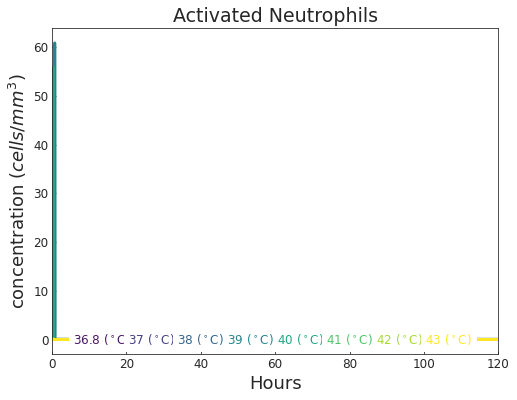

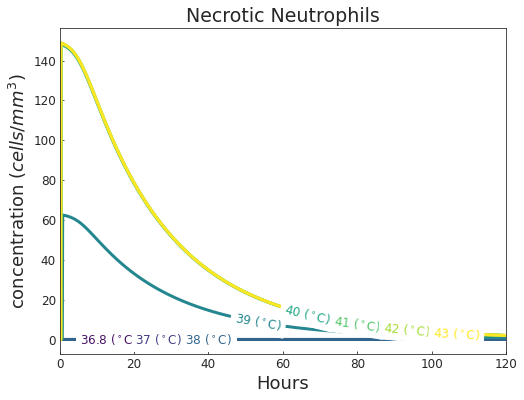

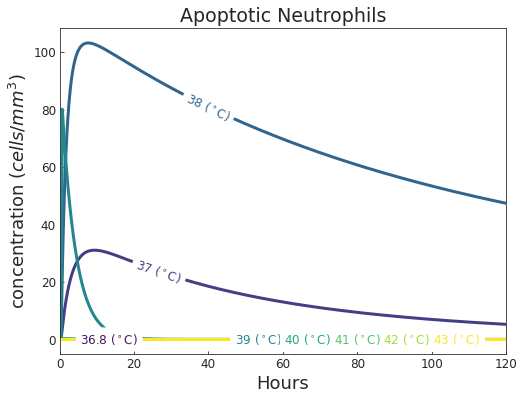

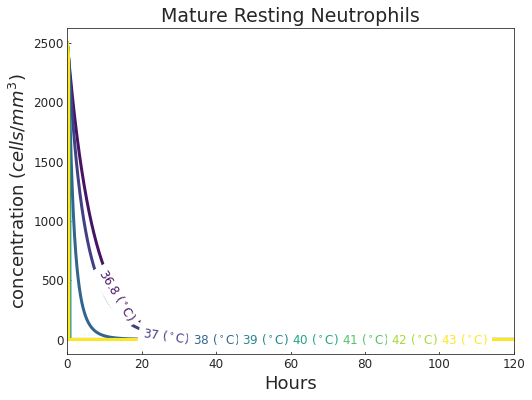

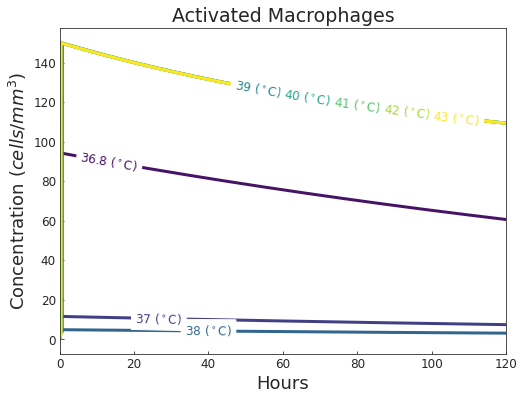

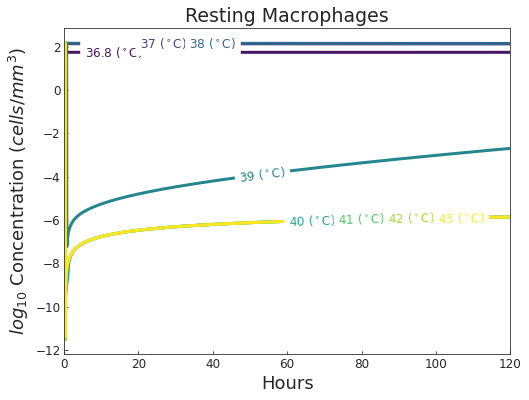

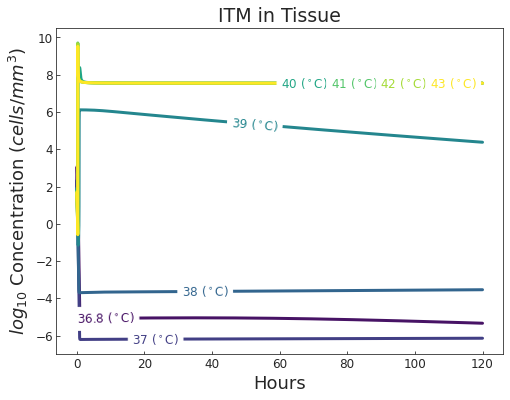

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


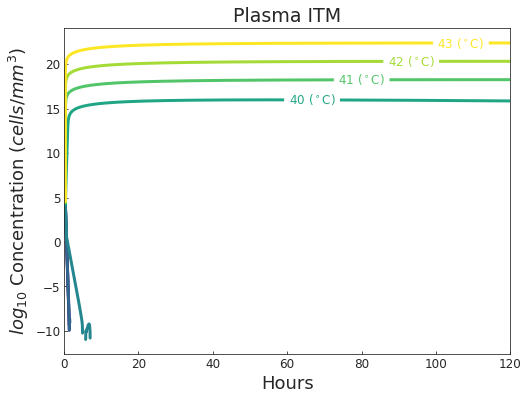

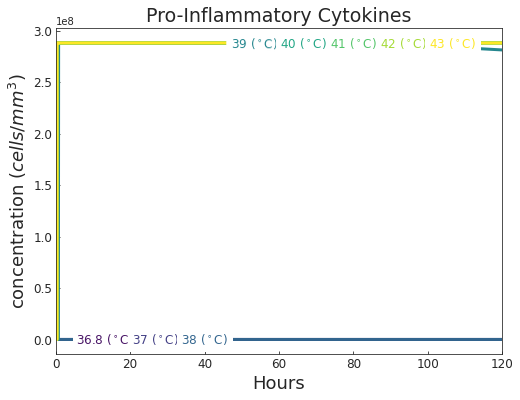

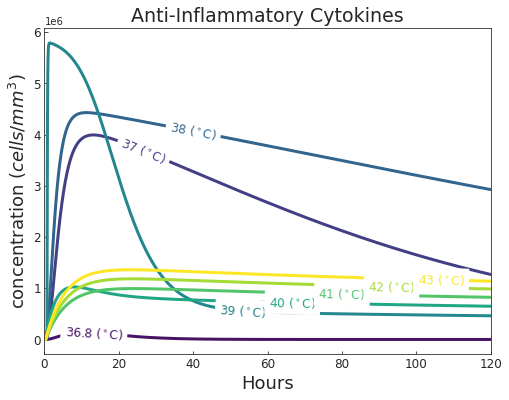

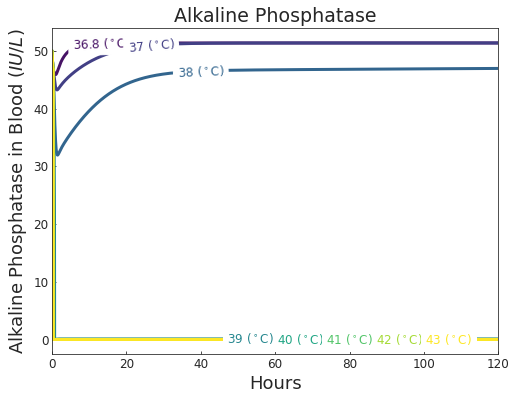

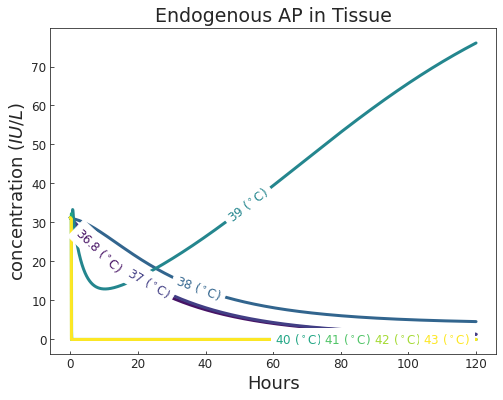

In [57]:
phi_MRA = prms.phi_MRA

mu_NR = prms.mu_NR
mu_NA = prms.mu_NA
mu_NDA = prms.mu_NDA
mu_NDN = prms.mu_NDN
mu_APE = prms.mu_APE
mu_APSfast = prms.mu_APSfast
mu_APSslow = prms.mu_APSslow
mu_APS = prms.mu_APS
mu_MA = prms.mu_MA
mu_MR = prms.mu_MR
mu_ACH = prms.mu_ACH
mu_CH = prms.mu_CH
mu_ITM = prms.mu_ITM

lamb_ITMNA = prms.lamb_ITMNA
lamb_APE = prms.lamb_APE
lamb_APS = prms.lamb_APS
lamb_ITMMA = prms.lamb_ITMMA
lamb_MANDA = prms.lamb_MANDA
lamb_MANDN = prms.lamb_MANDN
lamb_ITMNDN = prms.lamb_ITMNDN

Pmax_MR = prms.Pmax_MR
Pmin_MR = prms.Pmin_MR
Pmax_NR = prms.Pmax_NR
Pmin_NR = prms.Pmin_NR
Pmax_ITM = prms.Pmax_ITM
Pmin_ITM = prms.Pmin_ITM

Keq_CH = prms.Keq_CH
Mmax = prms.Mmax
Nmax = prms.Nmax
ACHmax = prms.ACHmax
CHmax_tissue = prms.CHmax_tissue

ITMblood0 = prms.ITMblood0
ITMmax = prms.ITMmax
APEbmax = convert_AP(prms.APEbmax, 'endo', 'tissue')
APElmax = convert_AP(prms.APElmax, 'endo', 'tissue')
APEmax = convert_AP(prms.APEmax, 'endo', 'tissue')
APSmax = convert_AP(prms.APSmax, 'supp', 'blood')

alpha_ITMNDN = prms.alpha_ITMNDN
alpha_ACHMA = prms.alpha_ACHMA
alpha_ACHMA = prms.alpha_ACHMA

beta_CHMA = prms.beta_CHMA
beta_CHNA = prms.beta_CHNA
beta_MANDA = prms.beta_MANDA

theta_ACH = prms.theta_ACH

ITM_source_peak = prms.ITM_source_peak
ITM_source_width = prms.ITM_source_width

# Initial Conditions
N_R0 = prms.N_R0
N_A0 = prms.N_A0
ND_A0 = prms.ND_A0
ND_N0 = prms.ND_N0
M_R0 = prms.M_R0
M_A0 = prms.M_A0
AP_S0 = convert_AP(prms.AP_S0, 'supp', 'blood')
AP_Ebt0 = AP_S0 + APEbmax
AP_St0 = prms.AP_St0
AP_Et0 = convert_AP(prms.AP_Et0, 'endo', 'tissue')
AP_El0 = convert_AP(prms.AP_El0, 'endo', 'blood')


if state == 'low':
    # low ITMs
    AP_Eb0 = convert_AP(250, 'endo', 'blood')
    folder = 'temp/low/'
elif state == 'average':
    # average ITMs
    AP_Eb0 = convert_AP(250, 'endo', 'blood')
    folder = 'temp/average/'
else:
    # High ITMs
    AP_Eb0 = convert_AP(prms.AP_Eb0, 'endo', 'blood') + AP_El0 #no liver gush
    folder = 'temp/high/'

CH0 = prms.CH0
ACH0 = prms.ACH0
N_B0 = prms.N_B0

AP_Sinj = (1 * 5.6 * 80.) / (60. * 5)
AP_Sinj = convert_AP(AP_Sinj, 'supp', 'blood')

step_max = prms.step_max

step = 'bIAP'
bound = 'bound_'
norm = 'norm_'
params = {'h': 'h4',
          'restrict': False}

beta_CHMA = 7.8e-4
beta_CHNA = 4.8e-2
theta_ACH = 1e-10
beta_MANDA = 9e1
lamb_ITMNDN = 1.e-6
alpha_ITMNDN = 1e3
Pmax_APE = 0.002
Pmin_APE = 0.0002
# rdistress = 3e6  # 1e6
rdistress = 4e6  # 1e6
w_gauss_min = 8e7
rinduce_peak = 21.0
rinduce = 0.05
r_AP = 0.08
r_ITM = 0.5
r_ITMpeak = 5 * 10 ** 12
r_NDN = 0.008
lamb_MANDN = 5e-6
lamb_MANDA = 3e-5
mu_NDA = 2.5e1
Keq_CH = 2e4
r_Nhomeo = 1e-4
Pmax_NR = 6e-3

r_APhomeo = Pmin_APE + prms.mu_APE

time = prms.time
t = [prms._stoptime * float(i) / (prms._numpoints - 1) for i in range(prms._numpoints)]
ITMtissue0 = prms.ITMtissue0
ITMtrans0 = prms.ITMtrans0
AP_filename = prms.AP_fle
pred_filename = prms.pred_fle

cyto_fle = prms.cyto_fle
sample_fle = prms.sample_fle
trt_fle = prms.trt_fle
german_hospital_file = prms.german_hospital_file
dutch_hospital_file = prms.dutch_hospital_file
treatment_file = prms.treatment_file

# case 5 is for placebo experiment
# case 6 is for bIAP experiment
cases = [5]
case_names = ['', '', '', 'No AP', 'Placebo', 'bIAP']
patients = ['16', '51', '36', '26', '59']
treatment = 'Placebo'

# df_median, cyto_dic = cyto.get_median(cyto_fle, sample_fle, trt_fle, 'time')
# df_IL10 = df_median[df_median['cytokine'] == 'il10']
# df_IL6 = df_median[df_median['cytokine'] == 'il6']

# df_median_restrict, cyto_dic_restrict = cyto.get_median_restrict(cyto_fle, sample_fle, trt_fle, 'time',
#                                                                  treatment=treatment,
#                                                                  patients=patients)
# df_IL10_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il10']
# df_IL6_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il6']

# df_cyto = cyto.get_data(cyto_fle, sample_fle, trt_fle, 'sample')

# df_AP, df_AP_median = dp.get_data(german_hospital_file=german_hospital_file,
#                                            dutch_hospital_file=dutch_hospital_file,
#                                            treatment_file=treatment_file,
#                                            parameter_name='AlkFosf',
#                                            restrict=False,
#                                            treatment=treatment,
#                                            patients=patients,
#                                            do_binning=True)

# df_AP_restrict, df_AP_median_restrict = dp.get_data(german_hospital_file=german_hospital_file,
#                                                      dutch_hospital_file=dutch_hospital_file,
#                                                      treatment_file=treatment_file,
#                                                      parameter_name='AlkFosf',
#                                                      restrict=True,
#                                                      treatment=treatment,
#                                                      patients=patients,
#                                                      do_binning=True)



# params_temp_track = {
#     'lamb_ITMNDN': [lamb_ITMNDN],
#     'Pmax_NR' : [Pmax_NR],
#     'Nmax': [Nmax],
#     'lamb_ITMMA' : [lamb_ITMMA],
#     'beta_CHNA' : [beta_CHNA],
#     'beta_CHMA' : [beta_CHMA],
#     'alpha_ACHMA' : [alpha_ACHMA],
#     'Pmax_APE' : [Pmax_APE],
#     'alpha_ITMNDN': [alpha_ITMNDN]
#     }

params_temp_track = {
    'lamb_ITMNDN': [],
    'Pmax_NR' : [],
    'Nmax': [],
    'lamb_ITMMA' : [],
    'beta_CHNA' : [],
    'beta_CHMA' : [],
    'alpha_ACHMA' : [],
    'Pmax_APE' : [],
    'alpha_ITMNDN': []
    }


for case in cases:
    print('Processing Case :', case, ' (', case_names[case-1], ')')

    # normal individuals
    if state == 'low':
        ITMblood0 = 0
        ITMtissue0 = 0
        r_ITMpeak = 1 * 10 ** 6
        
    elif state == 'average':
        ITMblood0 = 35000.0
        ITMtissue0 = 3500.0
        r_ITMpeak = 1 * 10 ** 7

    T0 = 36.8
    temperatures = [36.8, 37, 38, 39, 40, 41, 42, 43]
    
    w = [N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMblood0, ITMtissue0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0]
    params['case'] = case
    w0 = get_init(w, params)

    colors=cm.viridis(np.linspace(0.05,1,len(temperatures)))
 
    df_collect = {}
    
    #original linear response    
    temp_alpha = 0.002    
    ITM_factor = 4.75
    
    labels = ['36.8 ($^\circ$C)', '37 ($^\circ$C)', '38 ($^\circ$C)', '39 ($^\circ$C)', '40 ($^\circ$C)', '41 ($^\circ$C)', 
              '42 ($^\circ$C)', '43 ($^\circ$C)']
    labeled = []
    temp_now = 0
    for index, temperature in enumerate(temperatures):
        color = colors[index]
#         temperature = int(temperature) if temperature != T0 else T0
#         ITM_factor = ITM_factor * mult
        
        p = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,
         mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA,
         theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, beta_CHMA,
         beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE,
         Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max,
         r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width]
        
#         print (temperature)
        p, scaler = change_temp(p, temp_alpha, temperature, ITM_factor, T0)
    
        
        t, wsol = solve(p, w0, t, params)
        
        df_model = pd.DataFrame(wsol)
        keys = df_model.columns.values
        dictionary = dict(zip(keys, get_header()))
        df_model = df_model.rename(columns=dictionary)
        df_model['Time'] = t
        df_model['Time'] = df_model['Time']/60.
        
        df_collect[temperature] = df_model
        temp_now = temperature
        
        plot(wsol, case_names, time, t, params, temperature, folder, color)
#         labeled.append(labels[index])
        

In [58]:
# zipping
import os
from zipfile import ZipFile

def zip_files(dirName, zip_file):
#     dirName = './results/populated/quarantine/'
    # create a ZipFile object
    with ZipFile(zip_file, 'w') as zipObj:
        # Iterate over all the files in directory
        for folderName, subfolders, filenames in os.walk(dirName):
            for filename in filenames:
                #create complete filepath of file in directory
                filePath = os.path.join(folderName, filename)
                # Add file to zip
                zipObj.write(filePath)
                
if state == 'low':
    zip_file = './results/zip/low_temp.zip'
    dirName = './results/plots/temp/low/'
elif state == 'average':
    zip_file = './results/zip/average_temp.zip'
    dirName = './results/plots/temp/average/'
else:                
    zip_file = './results/zip/high_temp.zip'
    dirName = './results/plots/temp/high/'

In [59]:
state

'low'

In [60]:
zip_files(dirName, zip_file)

FileNotFoundError: [Errno 2] No such file or directory: './results/zip/low_temp.zip'

In [ ]:
def plot_params(params_dic, p, temp):
    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width = p
    
    if len(params_dic['lamb_ITMNDN'].values()) != 0:
    params_dic = {
        'lamb_ITMNDN': lamb_ITMNDN,
        'Pmax_NR' : Pmax_NR,
        'Nmax': Nmax,
        'lamb_ITMMA' : lamb_ITMMA,
        'beta_CHNA' : beta_CHNA,
        'beta_CHMA' : beta_CHMA,
        'alpha_ACHMA' : alpha_ACHMA,
        'Pmax_APE' : Pmax_APE,
        'alpha_ITMNDN': alpha_ITMNDN
    }

In [ ]:
np.squeeze(params_temp_track['beta_CHNA'])

In [ ]:
plt.plot(temperatures,np.squeeze(params_temp_track['lamb_ITMNDN']))
# alpha_ACHMA

# params_temp_track = {
#     'lamb_ITMNDN': [],
#     'Pmax_NR' : [],
#     'Nmax': [],
#     'lamb_ITMMA' : [],
#     'beta_CHNA' : [],
#     'beta_CHMA' : [],
#     'alpha_ACHMA' : [],
#     'Pmax_APE' : [],
#     'alpha_ITMNDN': []
#     }


In [ ]:
from sklearn.linear_model import LinearRegression
#linear
X= (np.array(temperatures)-T0).reshape(-1, 1)
y= np.squeeze(params_temp_track['beta_CHNA']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
# reg.intercept_

In [ ]:
from sklearn.linear_model import LinearRegression
#exponential
# X= (np.array(temperatures)-T0).reshape(-1, 1)
# y= np.log(np.squeeze(params_temp_track['lamb_ITMNDN'])).reshape(-1, 1)

#linear
X= (np.array(temperatures)-T0).reshape(-1, 1)
y= np.squeeze(params_temp_track['lamb_ITMNDN']).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_

In [ ]:
#exponential
X=(np.array(temperatures)-T0).reshape(-1, 1)
y= np.log(np.squeeze(params_temp_track['alpha_ITMNDN'])).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_

In [ ]:
#Arrhenious 

k = 1.38064852*(10**(-23))
E = temp_alpha
T = T0 + 273.15
R0_list = [0, 100]


R= R0*np.exp(-E/(k*T))

In [ ]:
pickle.dump(df_collect,  open('results/pickle/df_collect_low', "wb"))

In [ ]:
pickle.dump(df_collect,  open('results/pickle/df_collect_high', "wb"))

In [ ]:
params_temp = {
        'lamb_ITMNDN': lamb_ITMNDN,
        'Pmax_NR' : Pmax_NR,
        'Nmax': Nmax,
        'lamb_ITMMA' : lamb_ITMMA,
        'beta_CHNA' : beta_CHNA,
        'beta_CHMA' : beta_CHMA,
        'alpha_ACHMA' : alpha_ACHMA,
        'Pmax_APE' : Pmax_APE,
        'alpha_ITMNDN': alpha_ITMNDN
    }
params_temp

In [ ]:
lamb_ITMNDN*np.exp(temp_alpha * float(3.5))

In [ ]:
lamb_ITMNDN